# Deploy & Run Stable Diffusion Inpaint on SageMaker and Inferentia2

**SageMaker Studio Kernel: Data Science 3.0 (ml.t3.medium)**

Stable Diffusion is a transformer model that generates random images out of textual prompts (description of the scene). You can get more information of the model implementation at: https://github.com/Stability-AI/

This sample shows how to compile & deploy a pre-trained [HF Stable Diffusion 2 Inpaint](https://huggingface.co/stabilityai/stable-diffusion-2-inpainting) to [Inferentia2](https://aws.amazon.com/ec2/instance-types/inf2/) using SageMaker. You need to run two steps to complete this task: 1) A SageMaker Training Job using a Trainium instance for compiling the model and; 2) create a SageMaker real-time endpoint, hosted on an Inferentia2 instance, to deploy and invoke your model.

**Compilation:** First you'll kick-off a SageMaker training job on a **trn1.32xlarge** instance. It requires NeuronX Compiler v2.9 to compile the model. It takes ~22mins with a trn1.32xlarge. (Estimated compilation cost on 2023 Sep 30 - us-east-1 ml.trn1.32xlarge \\$24.73/h ::: 22mins=$9.02). You compile the model once and deploy & run as many times as you need.

**Inference:** After compiling the model it is time to deploy. You'll create a SageMaker real-time Endpoint hosted on an **inf2** instance. SageMaker exposes your model as a webservice and allow you to invoke it with a simple API call.


The compilation mechanism supports datatypes in FP32 or BF16. BF16 will give you a lower latency and it is selected by default.

## 1) Install some dependencies

In [2]:
%pip install -U sagemaker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.2/892.2 kB 8.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for urllib3<1.27,>=1.25.4 from https://files.pythonhosted.org/packages/c5/05/c214b32d21c0b465506f95c4f28ccbcba15022e000b043b72b3df7728471/urllib3-1.26.16-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.16-py2.py3-none-any.whl.metadata (48 kB)
Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Created wheel for sagemaker: filename=sagemaker-2.188.0-py2.py3-none-any.whl size=1193902 sha256=9363f36c103f4d81b0ab5eb19315d02f68706f68e5eba7587dff04ae8d20f130
  Stored in directory: /root/.cache/pip/wheels/94/00/3e/af9dde735e7ee826b11724be1de1a009a4179984f236a7a928
Successfully built sagemaker
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
  Attempting uninstall: sagemaker
    Found existing installation: sag

## 2) Initialize variables
Not all regions have trn1 and inf2 instances available at the time this notebook was published. us-east-1 has trn1 instances and us-east-2 has inf2 instances. That way, we need to create two sagemaker sessions: 1/ for compiling the model (us-east-1); 2/ for deploying the model (us-east-2).

In [3]:
import boto3
import sagemaker
import numpy as np

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

region_trn1='us-east-1'
boto3_sess_trn1 = boto3.Session(region_name=region_trn1) # trn1 session
sess_trn1 = sagemaker.Session(boto3_sess_trn1)

region_inf2='us-east-2'
boto3_sess_inf2 = boto3.Session(region_name=region_inf2) # inf2 session
sess_inf2 = sagemaker.Session(boto3_sess_inf2)

bucket_trn1 = sess_trn1.default_bucket()
bucket_inf2 = sess_inf2.default_bucket()
role = sagemaker.get_execution_role()

# https://github.com/aws/deep-learning-containers/blob/master/available_images.md#neuron-containers
train_image_name="pytorch-training-neuronx"
inference_image_name="pytorch-inference-neuronx"
# We need SDK2.13+ to deal with SD Inpaint
image_tag="1.13.1-neuronx-py310-sdk2.13.2-ubuntu20.04-v1.0"

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket trn1: {bucket_trn1}")
print(f"sagemaker bucket trn1: {bucket_inf2}")
print(f"sagemaker session regions. trn1: {region_trn1} inf2: {region_inf2}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
2.188.0
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::772327914095:role/service-role/AmazonSageMaker-ExecutionRole-20220822T202655
sagemaker bucket trn1: sagemaker-us-east-1-772327914095
sagemaker bucket trn1: sagemaker-us-ea

## 3) Visualize scripts
We have 3 scripts that will do the job. 
  - src-inpaint/wrapper.py: Helper class created to wrap the model and expose the parts that we will compile to inf2. It is also a way to put everything back together to compose a pipeline.
  - src-inpaint/compile.py: NeuronSDK compilation script that makes use of the wrapper, splits the model into 4 parts and compile each one individually.
  - src-inpaint/inference.py: SageMaker inference script that also makes use of wrapper to reload the compiled parts and re-build the pipeline responsible for getting the predictions.

In [4]:
!pygmentize src-inpaint/wrapper.py

import torch
import torch.nn as nn
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
#from diffusers.models.attention_processor import Attention

class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple

class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.device = unetwrap.unet.device

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None, return_dict=False):
        sample = self.unetwrap(sample, timestep.float().expand((sample.shape[0],)), encoder_hidden_states)[0]
        return UNet2DConditionO

In [5]:
!pygmentize src-inpaint/compile.py

# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: MIT-0

import os
os.environ["NEURON_FUSE_SOFTMAX"] = "1"
import time
import copy
import torch
import shutil
import argparse
import numpy as np
import torch_neuronx
import torch.nn as nn
from wrapper import NeuronTextEncoder, UNetWrap, NeuronUNet, get_attention_scores
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler
from diffusers.models.attention_processor import Attention

height = 512 // 8
width = 512 // 8

def compile_text_encoder(text_encoder, args):
    print("Compiling text encoder...")
    base_dir='text_encoder'
    os.makedirs(os.path.join(args.checkpoints_path, base_dir), exist_ok=True)
    os.makedirs(os.path.join(args.model_path, base_dir), exist_ok=True)
    t = time.time()
    # Apply the wrapper to deal with custom return type
    text_encoder = Neuron

In [6]:
!pygmentize src-inpaint/inference.py

import os
os.environ['NEURON_RT_NUM_CORES'] = '2'
import torch
import torch.nn as nn
import torch_neuronx
import time
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from diffusers.models.attention_processor import Attention

import threading
import argparse
import sys
import copy
import PIL
import math
import json
import requests
import io
from io import BytesIO
import base64
from PIL import Image


model_id = "stabilityai/stable-diffusion-2-inpainting"
dtype = torch.float32

class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, sample, timestep, encoder_hidden_states, cross_attention_kwargs=None):
        out_tuple = self.unet(sample, timestep, encoder_hidden_states, return_dict=False)
        return out_tuple

class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
      

## 4) Compile the model

In [7]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="compile.py", # Specify your train script
    source_dir="src-inpaint",
    image_uri=f"763104351884.dkr.ecr.{region_trn1}.amazonaws.com/{train_image_name}:{image_tag}",
    role=role,
    sagemaker_session=sess_trn1,
    instance_count=1,
    instance_type='ml.trn1.32xlarge',
    disable_profiler=True,
    output_path=f"s3://{bucket_trn1}/output",    
    volume_size = 384,
    
    # Parameters required to enable checkpointing
    # This is necessary for caching XLA HLO files and reduce training time next time    
    checkpoint_s3_uri=f"s3://{bucket_trn1}/checkpoints",
    hyperparameters={
        "dtype": "fp32"
    }
)
estimator.framework_version = '1.13.1' # workround when using image_uri
estimator._is_compiled_model = True

In [8]:
# it takes around 1141 seconds to complete the job on a trn1.32xlarge
# You will run this just once to compile the model.
estimator.fit()

INFO:sagemaker:Creating training-job with name: pytorch-training-neuronx-2023-09-30-04-54-35-074


Using provided s3_resource
2023-09-30 04:54:35 Starting - Starting the training job.........
2023-09-30 04:55:57 Starting - Preparing the instances for training.........
2023-09-30 04:57:32 Downloading - Downloading input data
2023-09-30 04:57:32 Training - Downloading the training image.....................
2023-09-30 05:00:43 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-30 05:01:22,877 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-30 05:01:22,878 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-30 05:01:23,307 sagemaker-training-toolkit INFO     Found 32 neurons on this instance
2023-09-30 05:01:23,316 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-09-30 05:01:23,317 sagemaker_pytorch_container.trainin

## 5) Deploy the model to inferentia2
We compiled the model in one region but we'll deploy to another region. So, we need to copy the models artifacts first and then create a PyTorchModel

In [9]:
import boto3
s3 = boto3.resource('s3', region_name=region_trn1)

model_name="stable-diffusion-neuron-inferentia"
model_data=f"s3://{sess_inf2.default_bucket()}/{model_name}/model.tar.gz"
copy_source = {
    'Bucket': sess_trn1.default_bucket(),
    'Key': estimator.model_data.split('/', 3)[-1]
}
print(copy_source)
print(model_data)
s3.meta.client.copy(copy_source, sess_inf2.default_bucket(), f'{model_name}/model.tar.gz')

{'Bucket': 'sagemaker-us-east-1-772327914095', 'Key': 'output/pytorch-training-neuronx-2023-09-30-04-54-35-074/output/model.tar.gz'}
s3://sagemaker-us-east-2-772327914095/stable-diffusion-neuron-inferentia/model.tar.gz


In [10]:
import logging
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.utils import name_from_base

# depending on the inf2 instance you deploy the model you'll have more or less accelerators
# we'll ask SageMaker to launch 1 worker per accelerator
model_data=model_data
instance_type_idx=1 # default ml.inf2.8xlarge
instance_types=['ml.inf2.xlarge', 'ml.inf2.8xlarge', 'ml.inf2.24xlarge','ml.inf2.48xlarge']
num_workers=[1,1,6,12]

print(f"Instance type: {instance_types[instance_type_idx]}. Num SM workers: {num_workers[instance_type_idx]}")
pytorch_model = PyTorchModel(
    image_uri=f"763104351884.dkr.ecr.{region_inf2}.amazonaws.com/{inference_image_name}:{image_tag}",
    model_data=model_data,
    role=role,    
    name=name_from_base('sd-inf2'),
    sagemaker_session=sess_inf2,
    container_log_level=logging.NOTSET,
    model_server_workers=num_workers[instance_type_idx], # 1 worker per inferentia chip
    framework_version="1.13.1",
    env = {
        'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600' 
    }
    # for production it is important to define vpc_config and use a vpc_endpoint
    #vpc_config={
    #    'Subnets': ['<SUBNET1>', '<SUBNET2>'],
    #    'SecurityGroupIds': ['<SECURITYGROUP1>', '<DEFAULTSECURITYGROUP>']
    #}
)
pytorch_model._is_compiled_model = True

Instance type: ml.inf2.8xlarge. Num SM workers: 1


In [11]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=instance_types[instance_type_idx],
    model_data_download_timeout=3600, # it takes some time to download all the artifacts and load the model
    container_startup_health_check_timeout=1800
)

INFO:sagemaker:Creating model with name: sd-inf2-2023-09-30-07-23-44-709
INFO:sagemaker:Creating endpoint-config with name sd-inf2-ml-inf2-2023-09-30-07-23-50-979
INFO:sagemaker:Creating endpoint with name sd-inf2-ml-inf2-2023-09-30-07-23-50-979


-------------!

## 6) Run a simple test

In [12]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer = JSONSerializer()
predictor.deserializer = BytesDeserializer(accept='image/jpeg')

In [13]:
import io
import time
from PIL import Image
import requests
import base64

In [14]:
def download_image(url):
    response = requests.get(url)
    encoded_image = base64.b64encode(response.content).decode('UTF-8')
    return encoded_image

In [15]:
#prompt = "a photo of an astronaut riding a horse on mars"
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
init_image = download_image(img_url)
mask_image = download_image(mask_url)

In [16]:
input_req={
    "prompt": prompt,
    "init_image": init_image,
    "mask_image": mask_image
}

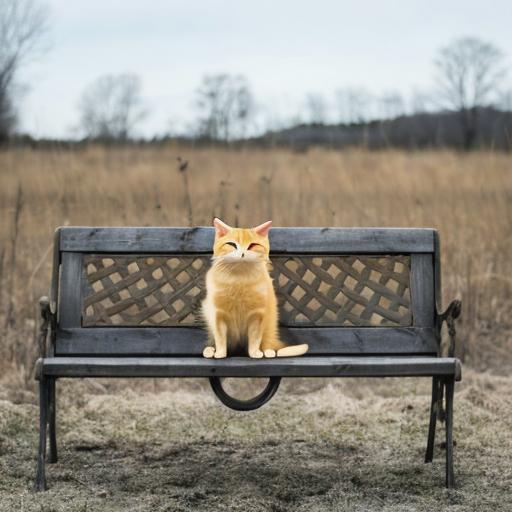

In [17]:
Image.open(io.BytesIO(predictor.predict(input_req)))

## 7) Cleanup
If you don't need the endpoint anymore, run the next cell to delete it.

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()